# Data Analysis Notebook

This notebook contains code for an interactive GUI that can run the lick detection algorithm and display results. It is based on the MATLAB lickDetector.m script, and all code for the analysis algorithms is contained in data_analysis.py.

### Imports

In [20]:
import os
import re
import h5py
import numpy as np
import pandas as pd

# Widget stuff
#import ipywidgets as widgets
import panel as pn
pn.extension()

# Plotting
import matplotlib.pyplot as plt

# Lick detection algorithm
from data_analysis import filter_data

### Load data and run analysis

In [2]:
# TODO: File picker GUI for selecting the animal-sensor map file
layout = pd.read_csv("layouts/default_layout.csv", header=None, index_col=0)

In [32]:
# Set the directory where data is stored (and where analysis files will be written)
data_dir = "Lickometry Data/AEW6"

In [34]:
fs = pn.widgets.FileSelector(
    directory=data_dir,
    only_files=True,
    file_pattern="*.h5",
)

pn.Column(
    "Select raw data files (click and drag for multiselect). Click the '>>' button to add file(s) to the list to process. Do not re-run the cell after selection or you'll need to select them again!",
    fs,
    pn.pane.Markdown("### Selected:\n" + "\n".join(fs.value) if fs.value else "### Selected:\n(none)")
)

Column
    [0] Markdown(str)
    [1] FileSelector(directory='/Users/christopher/TimmeL..., file_pattern='*.h5', only_files=True, root_directory='/Users/christopher/TimmeL...)
    [2] Markdown(str)

Total recording length: 7582.680193662643 seconds (126.37800322771072 minutes)


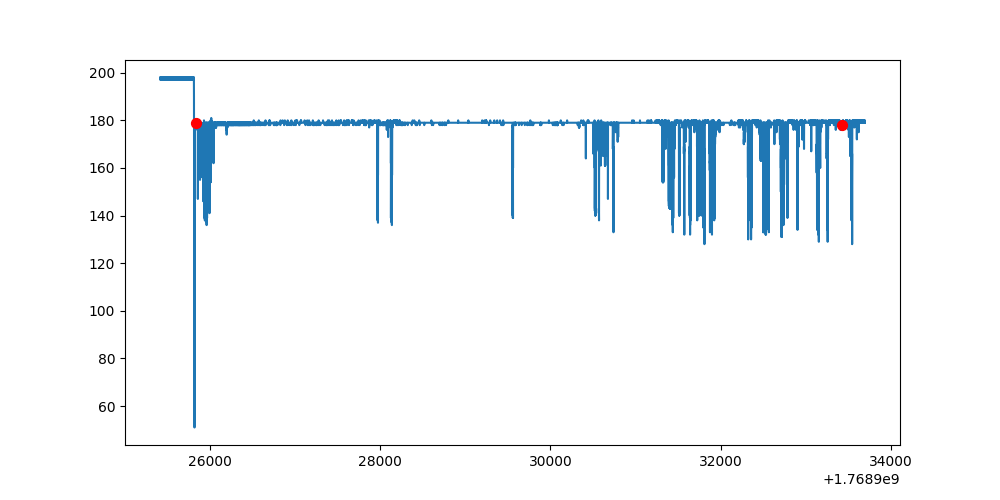

In [40]:
# Time fixes
#   An excel sheet can be used if there are errors in the start
#   and stop times. The user will be able to override the start/stop times
#   recorded and use the capacitance traces to identify start and stop
#   times. This file will have four columns, each with headers: File
#   Number, Sensor, New Start Time, New End Time. The code will produce
#   plots for the user and data tips can be used identify new start and
#   stop times. Example time fix file format:
#
#   Filename    Sensor    New Start Time      New End Time
#   ...         20        1756825855          1756833056
#   ...         2         1757083015          1757090258
#
#   This would be time fixes for two recordings.
#
# To plot a capacitive trace, change the change the filename listed and the sensor number,
# then re-run this cell. This is useful for determining start/stop times for the file.
# The matplotlib widget backend has been enabled so that you can move around the graph and zoom.
#
# In general, this step can be skipped until a problem is encountered. The automated analysis will
# account for accidental start/stops and use the last start_time/stop_time pair in the file. However,
# if no start or stop time is recorded, this can be used to fix that situation.
file = os.path.join(data_dir, "raw_data_2026-01-20_11-10-18.h5")
sensor = 3

# Determine which board did the recording based on sensor number
match sensor:
    case (1 | 2 | 3 | 7 | 8 | 9):
        board = 0
    case (4 | 5 | 6 | 10 | 11 | 12):
        board = 1
    case (13 | 14 | 15 | 19 | 20 | 21):
        board = 2
    case (16 | 17 | 18 | 22 | 23 | 24):
        board = 3

with h5py.File(file, 'r') as h5f:
    sensor_data = h5f[f'board_FT232H{board}'][f'sensor_{sensor}']
    cap_data = sensor_data['cap_data'][()]
    time_data = sensor_data['time_data'][()]

    # Determine which start time keys we have
    pattern = re.compile(r'^start_time(\d+)?$')
    matches = {}
    for k in sensor_data.keys():
        m = pattern.match(k)
        if m:
            num = int(m.group(1)) if m.group(1) else -1
            matches[num] = k
    if matches:
        num = -np.inf
        for n in matches.keys():
            if n > num: num = n
        last_start = matches[num]
        start_time = sensor_data[last_start][()]
        # Try the stop_time corresponding to the start_time above
        try:
            stop_time = sensor_data['stop' + last_start[5:]][()]
        except KeyError:
            # Stop time wasn't recorded (likely clicked stop all button too soon)
            stop_time = time_data[-1]
    else: # no start time recorded
        start_time = time_data[0] # start at beginning
        stop_time = time_data[-1] # stop at end    

total_recording_time = stop_time - start_time
print(f"Total recording length: {total_recording_time} seconds ({total_recording_time/60} minutes)")
start_idx = np.argmin(
    np.abs(time_data - start_time)
)
stop_idx = np.argmin(
    np.abs(time_data - stop_time)
)

%matplotlib widget
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time_data, cap_data, zorder=0)
ax.scatter(start_time, cap_data[start_idx], marker='o', c='r', s=50, zorder=1)
ax.scatter(stop_time, cap_data[stop_idx], marker='o', c='r', s=50, zorder=2)

In [38]:
# Change the filename below to select the time fix file you created (or skip this cell)
# This will be passed as an argument to the filter_data function, and any sensors included
# will have their start_time and stop_time values ignored and replaced with those in this file.
time_fix = os.path.join(data_dir, "time_fix.xlsx")
time_fix_df = pd.read_excel(time_fix, index_col=None, header=0)

time_fix_df.head() # For double checking the correct file was selected

,Filename,Sensor,New Start Time,New End Time
0,raw_data_2026-01-20_11-10-18.h5,3,1768843000,1768851100


In [7]:
# Loop through data files and run the filter_data script on them
for raw_data_filename in fs.value:
    print(f"Working on file: {raw_data_filename}")
    raw_data_filename_base = os.path.basename(raw_data_filename)
    filtered_data_filename_base = "filtered" + raw_data_filename_base[3:]
    filtered_data_filename = os.path.join(os.path.dirname(raw_data_filename), filtered_data_filename_base)
    with h5py.File(raw_data_filename, 'r') as raw_h5, h5py.File(filtered_data_filename, 'w') as filtered_h5:
        try:
            print(f"Comments from current raw data file:")
            print(raw_h5['comments'][()] + "\n")
        except KeyError:
            print("No comments in metadata\n")
        filter_data(raw_h5, filtered_h5, layout, raw_data_filename[:-3] + '.log', time_fix)
    print("") # newline to make space between each different file

Working on file: /Users/christopher/TimmeLab/Capacitive-Lick-Detection/Lickometry Data/AEW6/raw_data_2026-01-20_11-10-18.h5
Comments from current raw data file:
No comments in metadata

board_FT232H0 sensor_1 likely had a false start/stop, the stop time is less than 1000 seconds after start
Adjusted start and stop times for board_FT232H0 sensor_1
Animal A2 had 18 licks detected
Animal A3 had 36 licks detected
Animal A4 had 16 licks detected
Animal A5 had 2 licks detected
Animal A6 had 16 licks detected
Animal A7 had 59 licks detected
Animal A8 had 23 licks detected
Animal A9 had 23 licks detected
Animal A10 had 29 licks detected
Animal A11 had 15 licks detected
Animal A12 had 28 licks detected
Animal A13 had 29 licks detected
Animal A14 had 13 licks detected
Animal A15 had 19 licks detected
Animal A16 had 8 licks detected
Animal A17 had 33 licks detected
Animal A18 had 13 licks detected
Animal A19 had 2 licks detected
Animal A20 had 27 licks detected
Animal A21 had 6 licks detected
Ani

### Visualization

In [7]:
with h5py.File("/Users/christopher/TimmeLab/Capacitive-Lick-Detection/Lickometry Data/AEW6/raw_data_2026-01-19_12-13-37.h5", 'r') as h5f:
    print(h5f['board_FT232H0/sensor_1/weight'][()])

KeyError: "Unable to synchronously open object (object 'weight' doesn't exist)"